# Stock Market Predictions with LSTM

## Authors:

#### Abhijith Yayavaram Laxmi Narasimha
#### Bharat Kaushik
#### Krishna 

## Introduction :
Stock buyer wants to decide when to buy stocks and when to sell them to gain profit. This is where time series modelling comes in. machine learning models that can look at the history of a sequence of data and correctly predict the future elements of the sequence are going to be.

Stock market prices are highly unpredictable and volatile. This means that there are no consistent patterns in the data that allows us to model stock prices over time near-perfectly. 

In [33]:
#Libraries
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json 
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

## 2. Download data

Stock prices come in several different flavours. They are,
* Open: Opening stock price of the day
* Close: Closing stock price of the day
* High: Highest stock price of the data
* Low: Lowest stock price of the day

### Getting Data from Kaggle
Data found in Kaggle is a collection of csv files. We Used the AAL Stock Data for prediction


In [35]:
df=pd.read_csv("/Users/abhijith/Downloads/aal.txt")

### Data Exploration

Check the kind/Type of data we have, their structure, length and top observations

In [36]:
# Sort dataframe by date
df = df.sort_values('Date')

# Double check the result
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2013-12-10,23.698,24.345,23.610,24.064,18043837,0
1,2013-12-11,24.607,26.288,24.539,25.139,43224764,0
2,2013-12-12,25.342,25.832,24.616,24.616,20749989,0
3,2013-12-13,24.771,25.437,24.684,25.369,12588700,0
4,2013-12-16,25.749,25.888,25.485,25.739,17136729,0


#### Data Visualization

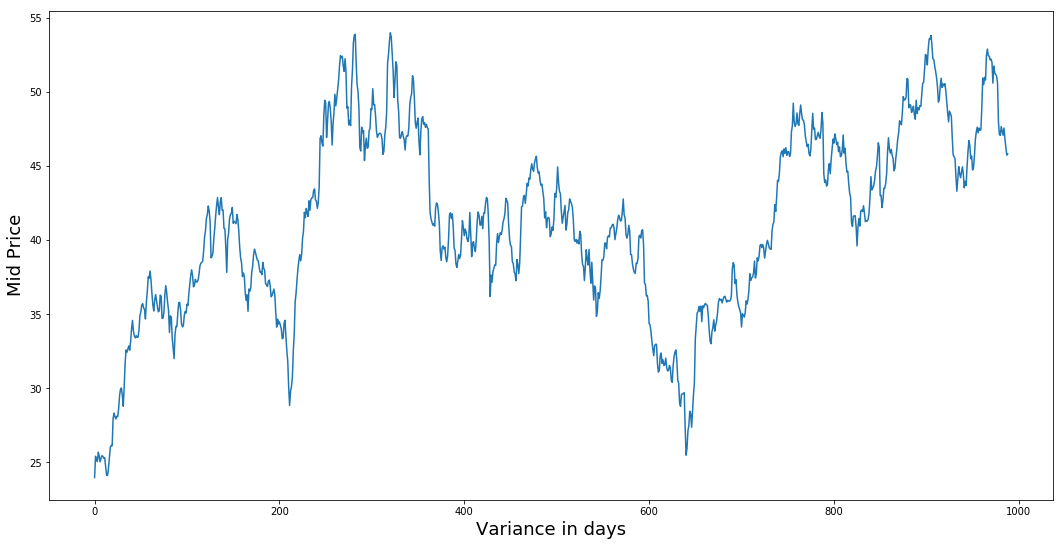

In [37]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xlabel('Variance in days',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

Graph Shows a varying trend over the time in days hence we first used time series forecasting to identify few steps ahead and then LSTM

## Breaking Data to Train and Test and Normalizing Data

we calculated mid price by taking the average of the highest and lowest recorded prices on a day

In [39]:
# First calculate the mid prices from the highest and lowest 
high_prices = df.loc[:,'High'].as_matrix()
low_prices = df.loc[:,'Low'].as_matrix()
mid_prices = (high_prices+low_prices)/2.0

/Users/abhijith/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/abhijith/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Test and train split is done from the original data frame. Train data will be the first 700 data points of the time series and rest will be test data.

In [40]:
train_data = mid_prices[:700]
test_data = mid_prices[700:]

we used a scaler to normalize data `MinMaxScalar` scales all the data to be in the region of 0 and 1. we reshaped the train and test data to be in the shape `[data_size, num_features]`.

In [41]:
#### Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data w.r.t training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

The observation we made earlier, that is, different time periods of data has different value ranges, we normalized data by breaking the full series to windows. If not the earlier data will all be close to 0 and will not add much value to learning. 

Here we choosed a window size of 160.

In [16]:
df.describe()

,Open,High,Low,Close,Volume,OpenInt
count,989.000000,989.000000,989.000000,989.000000,9.890000e+02,989.0
mean,41.150250,41.751690,40.537996,41.150520,1.004541e+07,0.0
std,6.344948,6.346726,6.284963,6.304682,6.971825e+06,0.0
min,23.698000,24.345000,23.610000,23.967000,2.246383e+06,0.0
25%,36.770000,37.343000,36.143000,36.809000,6.326115e+06,0.0
50%,41.241000,41.741000,40.594000,41.231000,8.685476e+06,0.0
75%,46.265000,46.960000,45.695000,46.315000,1.189551e+07,0.0
max,54.333000,54.634000,53.624000,54.317000,1.414300e+08,0.0


In [42]:
smoothing_window_size = 160
for di in range(0,480,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

In [43]:
# Train the Scaler with training data and smooth data 
smoothing_window_size = 160
for di in range(0,480,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# we again normalized the last bit of remaining data 
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

Reshape data back to the shape of `[data_size]`

In [19]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

we smoothened data using exponential moving average. This helps us to get rid of the inherent raggedness of the data in stock prices and preduce a smoother curve. Note that we should only smooth training data. 

In [20]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(700):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

## One-Step Ahead Prediction via Averaging 

Averaging mechanisms allows us to predict (often one time step ahead) by representing the future stock price as an average of the previously observed stock prices. Doing this for more than one time step can produce quite bad results. 

Mean squared error (MSE) can be calculated by taking the mean squared error between the true value at one step ahead and the predicted value and averaging it over all the predictions.

### Standard Average

Using standerd average we first tried to predict the future stock market prices (for example, $x_{t+1}$) as an average of the previously observed stock market prices within a fixed size window (for example, $x_{t-N},\ldots,x_{t}$) (say previous 100 days). Thereafter we will try a bit more fancier "exponential moving average" method and see how well that does. Then we will move on to the "holy-grail" of time-series prediction; Long Short-Term Memory models.
 
 AVG:

$x_{t+1} = 1/N \sum_{i=t-N}^{t} x_i$

the prediction at $t+1$ is the average value of all the stock prices you observed withing a window of $t$ to $t-N$.

In [21]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):
    
    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']
        
    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 60.05664



Below we observed that it follows the actual behavior of stock quite closely. Next we look at a more accurate one-step prediction method

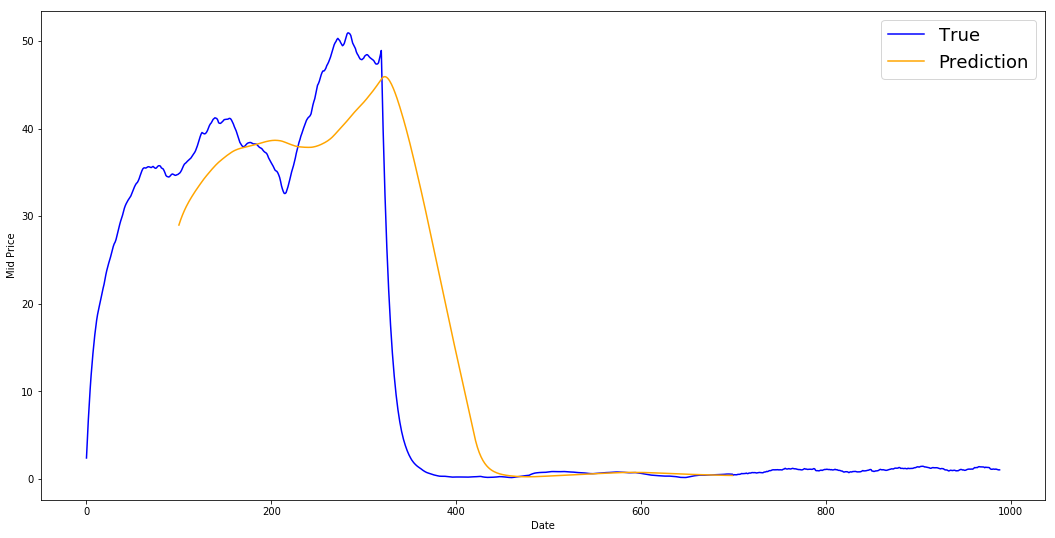

In [22]:

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

### Exponential Moving Average (Replicating Some of the so-called amazing stock market prediction learning)

In the exponential moving average method, we calculate $x_{t+1}$ as,

* $x_{t+1} = EMA_{t} = \gamma \times EMA_{t-1} + (1-\gamma) x_t$ where $EMA_0 = 0$ and $EMA$ is the exponential moving average value you maintain over time.

The above equation basically calulates the exponential moving averag from $t+1$ time step and uses that as the one step ahead prediction. $\gamma$ decides what is the contribution of the most recent prediction to the EMA. For example, a $\gamma=0.1$ gets only 10% of the current value into the EMA. Because we take only a very small fraction of the most recent, it allows to preserve much older values we saw very early in the average.


In [23]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):
    
    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.42412


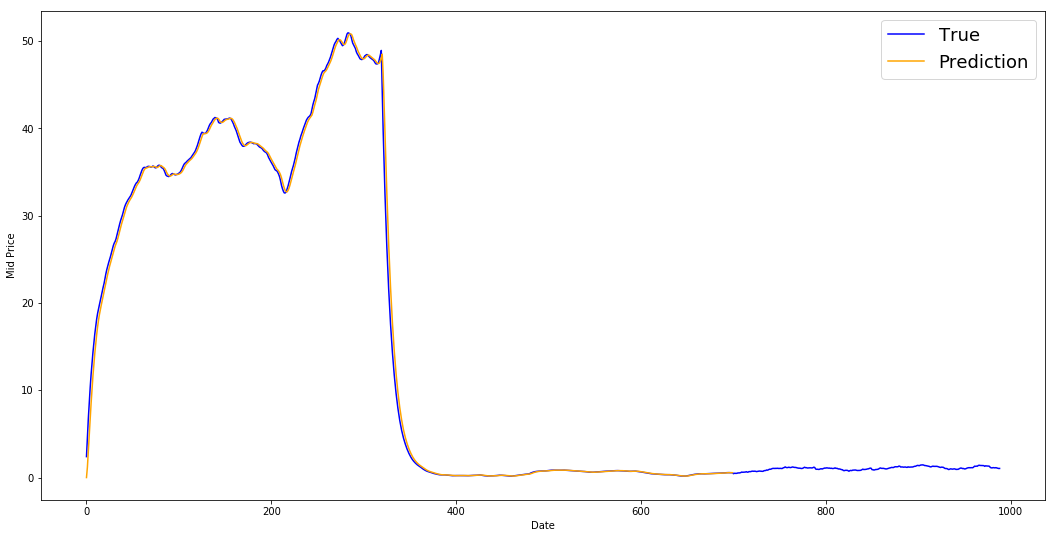

In [24]:

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

## Introduction to LSTM: Making Stock Movement Predictions Far into the Future

Long Short-Term Memory (LSTM) models are extremely powerful time-series models. A LSTM can predict an arbitrary number of steps into the future. A LSTM module (or a cell) has 5 essential components which allows them to model both long-term and short-term data. 
* Cell state ($c_t$) - This represents the internal memory of the cell which stores both short term memory and long-term memories
* Hidden state ($h_t$) - This is output state information calculated w.r.t. current input, previous hidden state and current cell input which you eventually use to predict the future stock market prices. Additionally, the hidden state can decide to only retrive the short or long-term or both types of memory stored in the cell state to make the next prediction.
* Input gate ($i_t$) - Decides how much information from current input flows to the cell state
* Forget gate ($f_t$) - Decides how much information from the current input and the previous cell state flows into the current cell state
5. Output gate ($o_t$) - Decides how much information from the current cell state flows into the hidden state, so that if needed LSTM can only pick the long-term memories or short-term memories and long-term memories

An LSTM cell looks like below.

<img src="lstm.png" alt="Drawing" style="width: 400px;"/>

And the equations for calculating each of these entities are as follows.

* $i_t = \sigma(W_{ix}x_t + W_{ih}h_{t-1}+b_i)$
* $\tilde{c}_t = \sigma(W_{cx}x_t + W_{ch}h_{t-1} + b_c)$
* $f_t = \sigma(W_{fx}x_t + W_{fh}h_{t-1}+b_f)$
* $c_t = f_t c_{t-1} + i_t \tilde{c}_t$
* $o_t = \sigma(W_{ox}x_t + W_{oh}h_{t-1}+b_o)$
* $h_t = o_t tanh(c_t)$



### Data Generator for LSTM

We first implemented a data generator to train our LSTM. This data generator will have a method called **unroll_batches(...)** which will output a set of *num_unrollings* batches of input data obtained sequentially, where a batch of data is of size *[batch_size, 1]*. Then each batch of input data will have a corresponding output batch of data. 

For example if *num_unrollings=3* and *batch_size=4* a set of unrolled batches it might look like,
* input data: $[x_0,x_10,x_20,x_30], [x_1,x_11,x_21,x_31], [x_2,x_12,x_22,x_32]$
* output data: $[x_1,x_11,x_21,x_31], [x_2,x_12,x_22,x_32], [x_3,x_13,x_23,x_33]$

#### Data Augmentation
Also to make our model robust we will not make the output for $x_t$ always $x_{t+1}$. Rather you will randomly sample an output from the set $x_{t+1},x_{t+2},\ldots,x_{t+N}$ where $N$ is a small window size.
* $x_{t+1},x_{t+2},\ldots,x_{t+N}$ will not be very far from each other

Below we illustrate how a batch of data is created visually.

<img src="batch.png" alt="Drawing" style="width: 600px;"/>

In [25]:

class DataGeneratorSeq(object):
    
    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):
        
        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)
        
        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)
                
            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(1,5)]
            
            self._cursor[b] = (self._cursor[b]+1)%self._prices_length
            
        return batch_data,batch_labels
    
    def unroll_batches(self):
            
        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):
            
            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels
    
    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))
        


dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)
    



Unrolled index 0
	Inputs:  [ 2.39775    41.24429    49.558113    0.24297439  0.6746985 ]

	Output: [ 6.7517924  41.159187   50.827625    0.25863257  0.68294376]


Unrolled index 1
	Inputs:  [ 4.699325   41.20026    49.7521      0.24579431  0.68294376]

	Output: [10.293047   41.159187   50.11059     0.25160438  0.7214227 ]


Unrolled index 2
	Inputs:  [ 6.7517924  41.159187   50.11059     0.25160438  0.69350255]

	Output: [13.128418   40.676044   50.94871     0.25214413  0.72824913]


Unrolled index 3
	Inputs:  [ 8.582664   40.99172    50.48408     0.25214413  0.7030209 ]

	Output: [10.293047   40.604572   50.827625    0.25863257  0.7214227 ]


Unrolled index 4
	Inputs:  [10.293047   40.676044   50.827625    0.25863257  0.7125452 ]

	Output: [15.4565735  40.796555   50.639217    0.29209375  0.73018414]


### Defining Hyperparameters

Here we define several hyperparameters. `D` is the dimensionality of the input. It's straightforward as we take the previous stock price as the input and predict the next, and should be 1. Then we have `num_unrollings`, this is a hyperparameter related to the backpropagation through time (BPTT) that is used to optimize the LSTM model. This denotes how many continuous time steps you consider for a single optimization step. we can think of this as, instead of optimizing the LSTM by looking at a single time step, we optimize the network looking at `num_unrollings` time steps. Larger the better. Then we have the `batch_size`. Batch size is how many data samples we consider in a single time steps. Next we define `num_nodes` which represents the number of hidden neurons in each LSTM cell.

In [26]:
D = 1 # Dimensionality of the data. Since our data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.reset_default_graph() # This is important in case you run this multiple times

### Defining Inputs and Outputs

Next we define placeholders for training inputs and labels. This is very straightforward as you have a list of input placeholders, where each placeholder contains a single batch of data. And the list has `num_unrollings` placeholders, that will be used at once for a single optimization step.

In [27]:
# Input data.
train_inputs, train_outputs = [],[]

# we unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))


### Defining Parameters of the LSTM and Regression layer 

we have a three layers of LSTMs and a linear regression layer (denoted by `w` and `b`), that takes the output of the last LSTM cell and output the prediction for the next time step. we can use the `MultiRNNCell` in TensorFlow to encapsualate the three `LSTMCell` objects created. Additionally we can have the dropout implemented LSTM cells, as they improve performance and reduce overfitting.

In [28]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

### Calculating LSTM output and Feeding it to the regression layer to get final prediction

we create a TensorFlow variables (`c` and `h`) that will hold the cell state and the hidden state of the LSTM. Then transform the list of `train_inputs` to have a shape of `[num_unrollings, batch_size, D]`, this is needed for calculating the outputs with the `tf.nn.dynamic_rnn` function.  we then calculate the lstm outputs with the `tf.nn.dynamic_rnn` function and split the output back to a list of `num_unrolling` tensors. the loss between the predictions and true stock prices.

In [29]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of 
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

### Loss Calculation and Optimizer
We calculated and loss and used adam optimizer

In [30]:
# we calculate loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and 
# get the sum of that over all the unrolled steps

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


### Prediction Related Calculations

Here we define the prediction related TensorFlow operations. First we define a placeholder for feeding in the input (`sample_inputs`), then similar to the training stage, we define state variables for prediction (`sample_c` and `sample_h`). Finally we calculate the prediction with the `tf.nn.dynamic_rnn` function and then sending the output through the regression layer (`w` and `b`).


In [31]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


### Running the LSTM

Here we will train and predict stock price movements for several epochs and see whether the predictions get better or worse over time. we followed the following procedure.
* Define a test set of starting points (`test_points_seq`) on the time series to evaluate the LSTM at
* For each epoch
 * For full sequence length of training data
   * Unroll a set of `num_unrollings` batches
   * Train the LSTM with the unrolled batches
 * Calculate the average training loss
 * For each starting point in the test set
   * Update the LSTM state by iterating through the previous `num_unrollings` data points found before the test point
   * Make predictions for `n_predict_once` steps continuously, using the previous prediction as the current input
   * Calculate the MSE loss between the `n_predict_once` points predicted and the true stock prices at those time stamps

In [32]:
epochs = 30
valid_summary = 1 # Interval you make test predictions

n_predict_once = 50 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings) 

x_axis_seq = []

# Points you start our test predictions from
test_points_seq = np.arange(700,800,5).tolist() 

for ep in range(epochs):       
    
    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):
        
        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)
        
        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l
    
    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))
      
      # The average loss
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))
      
      train_mse_ot.append(average_loss)
            
      average_loss = 0 # reset loss
      
      predictions_seq = []
      
      mse_test_loss_seq = []
      
      # ===================== Updating State and Making Predicitons ========================
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []
        
        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]
        
        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_mid_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)
        
        feed_dict = {}
        
        current_price = all_mid_data[w_i-1]
        
        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)
        
        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)
        
          our_predictions.append(np.asscalar(pred))
        
          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2
        
        session.run(reset_sample_states)
        
        predictions_seq.append(np.array(our_predictions))
        
        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)
        
        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)
        
      current_test_mse = np.mean(mse_test_loss_seq)
      
      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0
      
      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')
      
      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')

Initialized
Average loss at step 1: 23906.697266
	Test MSE: 0.44498
	Finished Predictions
Average loss at step 2: 21159.337891
	Test MSE: 0.43547
	Finished Predictions
Average loss at step 3: 17669.667969
	Test MSE: 0.42565
	Finished Predictions
Average loss at step 4: 14940.920898
	Test MSE: 0.41540
	Finished Predictions
Average loss at step 5: 13743.909180
	Test MSE: 0.40453
	Finished Predictions
Average loss at step 6: 10606.797852
	Test MSE: 0.39289
	Finished Predictions
Average loss at step 7: 7836.342773
	Test MSE: 0.38023
	Finished Predictions
Average loss at step 8: 9470.386719
	Test MSE: 0.36631
	Finished Predictions
Average loss at step 9: 11855.633789
	Test MSE: 0.35094
	Finished Predictions
Average loss at step 10: 14719.443359
	Test MSE: 0.33393
	Finished Predictions
Average loss at step 11: 15824.539062
	Test MSE: 0.31499
	Finished Predictions
Average loss at step 12: 17279.333984
	Test MSE: 0.29372
	Finished Predictions
Average loss at step 13: 18130.251953
	Test MSE: 0.

## Visualizing the LSTM Predictions

we can see how the MSE loss is going down with the amount of training. This is good sign that the model is learning something useful. To quantify our findings, we compared the LSTM's MSE loss to the MSE loss obtained when doing the standard averaging. we observed that the LSTM is doing better than the standard averaging.

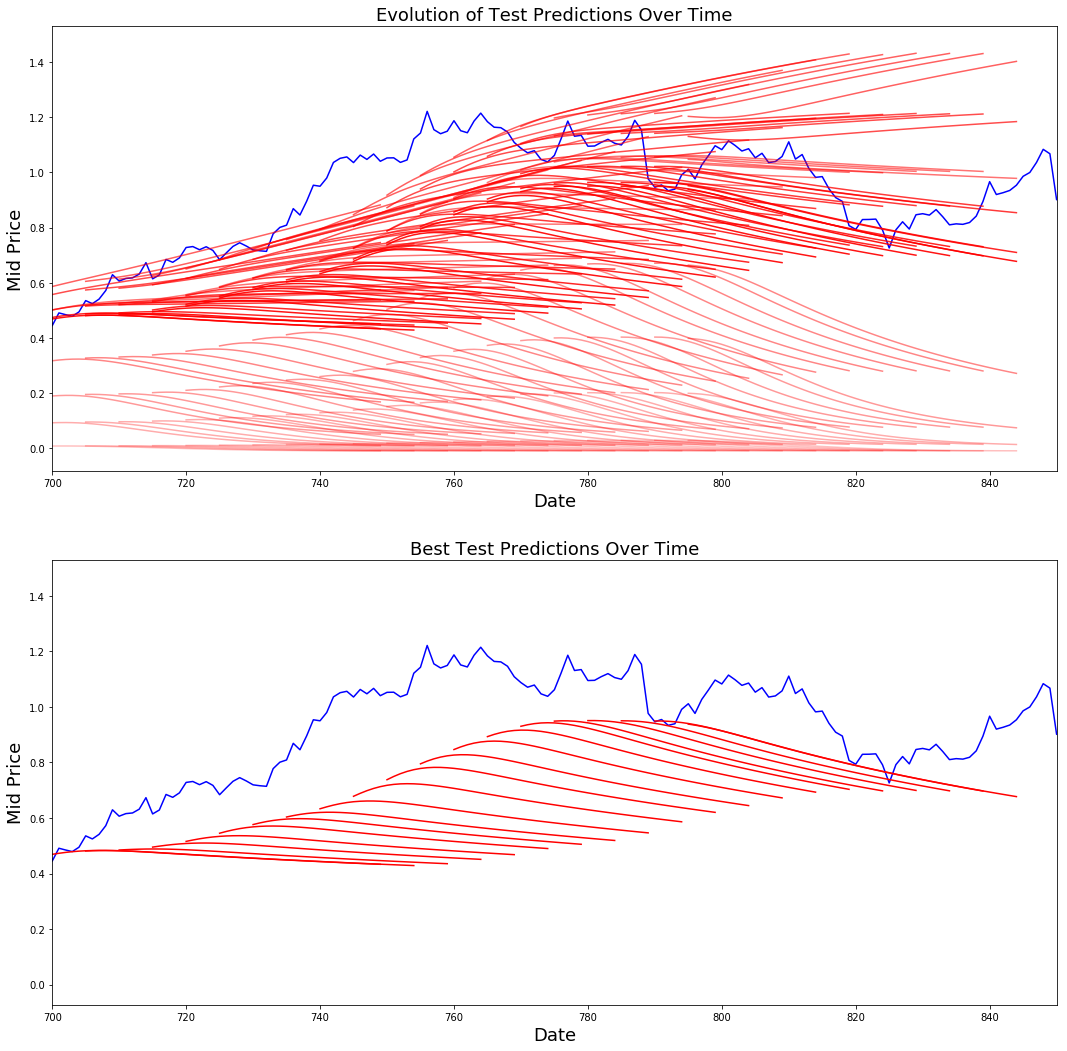

In [94]:
best_prediction_epoch = 28 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(df.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(700,850)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(df.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')
    
plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(700,850)
plt.show()

LSTM seems to be able to predict stock price behavior correctly most of the time

Note : we are making predictions roughly in the range of 0 and 1.0  as we are predicting the stock price movement, not the actual prices.